## Code
### Let’s see how we could go about implementing Linear Discriminant Analysis from scratch using Python. To start, import the following libraries.

In [1]:
from sklearn.datasets import load_wine
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### In the proceeding tutorial, we’ll be working with the wine dataset which can be obtained from the UCI machine learning repository. Fortunately, the scitkit-learn library provides a wrapper function for downloading and

In [4]:
wine = load_wine()
x = pd.DataFrame(wine.data, columns=wine.feature_names)
y = pd.Categorical.from_codes(wine.target, wine.target_names)

In [5]:
x.shape

(178, 13)

## The features are composed of various characteristics such as the magnesium and alcohol content of the wine.

In [7]:
x.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


### There are 3 different kinds of wine.

In [8]:
wine.target_names

array(['class_0', 'class_1', 'class_2'], dtype='<U7')

### We create a DataFrame containing both the features and classes.

In [9]:
df = X.join(pd.Series(y, name='class'))

In [10]:
class_feature_means = pd.DataFrame(columns=wine.target_names)
for c, rows in df.groupby('class'):
    class_feature_means[c] = rows.mean()
class_feature_means

,class_0,class_1,class_2
alcohol,13.744746,12.278732,13.153750
malic_acid,2.010678,1.932676,3.333750
ash,2.455593,2.244789,2.437083
alcalinity_of_ash,17.037288,20.238028,21.416667
magnesium,106.338983,94.549296,99.312500
total_phenols,2.840169,2.258873,1.678750
flavanoids,2.982373,2.080845,0.781458
nonflavanoid_phenols,0.290000,0.363662,0.447500
proanthocyanins,1.899322,1.630282,1.153542
color_intensity,5.528305,3.086620,7.396250


### Then, we plug the mean vectors (mi) into the equation from before in order to obtain the within class scatter matrix.

In [14]:
within_class_scatter_matrix = np.zeros((13,13))
for c, rows in df.groupby('class'):
    rows = rows.drop(['class'], axis=1)
    s = np.zeros((13,13))
    for index, row in rows.iterrows():
        x, mc = row.values.reshape(13,1), class_feature_means[c].values.reshape(13,1)
        s += (x - mc).dot((x - mc).T)
    within_class_scatter_matrix += s

## Between Class Scatter Matrix
### Next, we calculate the between class scatter matrix using the following formula.

In [15]:
feature_means = df.mean()
between_class_scatter_matrix = np.zeros((13,13))
for c in class_feature_means:    
    n = len(df.loc[df['class'] == c].index)
    
    mc, m = class_feature_means[c].values.reshape(13,1), feature_means.values.reshape(13,1)
    
    between_class_scatter_matrix += n * (mc - m).dot((mc - m).T)

### Then, we solve the generalized eigenvalue problem for

### to obtain the linear discriminants

In [16]:
eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(within_class_scatter_matrix).dot(between_class_scatter_matrix))

### The eigenvectors with the highest eigenvalues carry the most information about the distribution of the data. Thus, we sort the eigenvalues from highest to lowest and select the first k eigenvectors. In order to ensure that the eigenvalue maps to the same eigenvector after sorting, we place them in a temporary array.

In [18]:
pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
pairs = sorted(pairs, key=lambda x: x[0], reverse=True)
for pair in pairs:
    print(pair[0])

9.081739435042469
4.128469045639493
8.301164656845475e-16
6.220260092356696e-16
6.220260092356696e-16
5.149249584290688e-16
5.149249584290688e-16
1.8931182654809792e-16
1.8066202080581507e-16
7.487157321002816e-17
7.487157321002816e-17
6.316361304006824e-18
0.0


### Just looking at the values, it’s difficult to determine how much of the variance is explained by each component. Thus, we express it as a percentage.

In [19]:
eigen_value_sums = sum(eigen_values)
print('Explained Variance')
for i, pair in enumerate(pairs):
    print('Eigenvector {}: {}'.format(i, (pair[0]/eigen_value_sums).real))

Explained Variance
Eigenvector 0: 0.6874788878860778
Eigenvector 1: 0.3125211121139222
Eigenvector 2: 6.283901324483062e-17
Eigenvector 3: 4.708676703666665e-17
Eigenvector 4: 4.708676703666665e-17
Eigenvector 5: 3.8979321119880345e-17
Eigenvector 6: 3.8979321119880345e-17
Eigenvector 7: 1.433072209457855e-17
Eigenvector 8: 1.3675940169302205e-17
Eigenvector 9: 5.667705647455687e-18
Eigenvector 10: 5.667705647455687e-18
Eigenvector 11: 4.781424391025773e-19
Eigenvector 12: 0.0


### First, we create a matrix W with the first two eigenvectors.

In [20]:
w_matrix = np.hstack((pairs[0][1].reshape(13,1), pairs[1][1].reshape(13,1))).real

### Then, we save the dot product of X and W into a new matrix Y.

### where X is a n×d matrix with n samples and d dimensions, and Y is a n×k matrix with n samples and k ( k<n) dimensions. In other words, Y is composed of the LDA components, or said yet another way, the new feature space.

In [21]:
X_lda = np.array(X.dot(w_matrix))

### matplotlib can’t handle categorical variables directly. Thus, we encode every class as a number so that we can incorporate the class labels into our plot.

In [22]:
le = LabelEncoder()
y = le.fit_transform(df['class'])

### Then, we plot the data as a function of the two LDA components and use a different color for each class.

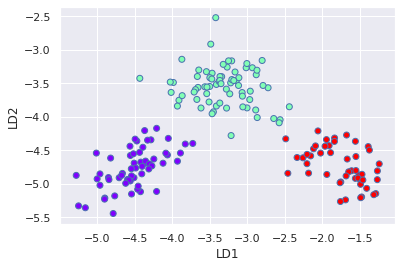

In [34]:
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y,
    cmap='rainbow',
    alpha=1,
    edgecolors='b'
)

### Rather than implementing the Linear Discriminant Analysis algorithm from scratch every time, we can use the predefined LinearDiscriminantAnalysis class made available to us by the scikit-learn library.

In [36]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X, y)

### We can access the following property to obtain the variance explained by each component.

In [37]:
lda.explained_variance_ratio_

array([0.6875, 0.3125])

### Just like before, we plot the two LDA components.

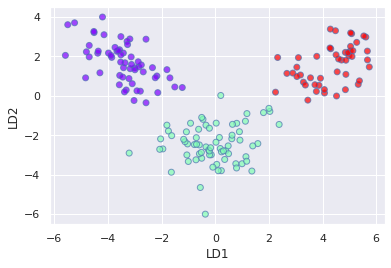

In [38]:
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)

### Next, let’s take a look at how LDA compares to Principal Component Analysis or PCA. We start off by creating and fitting an instance of the PCA class.

In [40]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X, y)

### We can access the explained_variance_ratio_ property to view the percentage of the variance explained by each component.

In [41]:
pca.explained_variance_ratio_

array([0.9981, 0.0017])

### As we can see, PCA selected the components which would result in the highest spread (retain the most information) and not necessarily the ones which maximize the separation between classes.

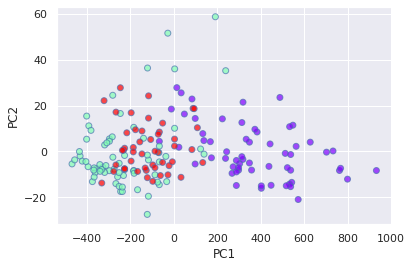

In [42]:
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.scatter(
    X_pca[:,0],
    X_pca[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)

### Next, let’s see whether we can create a model to classify the using the LDA components as features. First, we split the data into training and testing sets.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, random_state=1)

### Then, we build and train a Decision Tree. After predicting the category of each sample in the test set, we create a confusion matrix to evaluate the model’s performance.

In [44]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[18,  0,  0],
       [ 0, 17,  0],
       [ 0,  0, 10]])

### As we can see, the Decision Tree classifier correctly classified everything in the test set.